<a href="https://colab.research.google.com/github/patilprajwal/BSE-closure-anomaly-detection/blob/master/BSE_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14,8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version', tf.__version__)








/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Tensorflow version 2.3.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls

drive  sample_data


In [4]:
df = pd.read_csv('/content/drive/My Drive/BSE_1991_2019.csv', parse_dates=['date'])
df.tail(10)

,date,close
7011,2019-12-17,41352.17
7012,2019-12-18,41558.57
7013,2019-12-19,41673.92
7014,2019-12-20,41681.54
7015,2019-12-23,41642.66
7016,2019-12-24,41461.26
7017,2019-12-26,41163.76
7018,2019-12-27,41575.14
7019,2019-12-30,41558.00
7020,2019-12-31,41253.74


In [5]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date,y=df.close, mode ='lines', name='close'))
fig.update_layout(showlegend=True)
fig.show()

In [6]:
train_size = int(len(df)*0.8)
test_size = len(df)-train_size
train,test = df.iloc[0:train_size],df.iloc[train_size:len(df)]

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

In [8]:
train.mean()

close    2.282125e-16
dtype: float64

Train Test split


In [9]:
def create_sequences(X,y,time_steps=1):
  Xs,ys = [],[]
  for i in range(len(X)-time_steps):
    Xs.append(X.iloc[i:(i+time_steps)].values)
    ys.append(y.iloc[i+time_steps])
  return np.array(Xs), np.array(ys)

In [10]:
time_steps = 30

X_train,y_train = create_sequences(train[['close']],train.close,time_steps)
X_test,y_test = create_sequences(test[['close']],test.close,time_steps)

In [11]:
print(X_train.shape)

(5586, 30, 1)


Build an LSTM Autocoder

In [12]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout,RepeatVector, TimeDistributed

model = Sequential([
        LSTM(200,input_shape = (timesteps,num_features)),
        Dropout(0.2),
        RepeatVector(timesteps),
        LSTM(200,return_sequences=True),
        Dropout(0.2),
        TimeDistributed(Dense(num_features))

])
model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             201       
Total params: 482,601
Trainable params: 482,601
Non-trainable params: 0
__________________________________________________

In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,mode='min')
history = model.fit(
    X_train,y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[es],
    shuffle=False
)

Epoch 1/100
158/158 [==============================] - 25s 157ms/step - loss: 0.1265 - accuracy: 0.0000e+00 - val_loss: 0.1067 - val_accuracy: 0.0000e+00
Epoch 2/100
158/158 [==============================] - 24s 150ms/step - loss: 0.0870 - accuracy: 0.0000e+00 - val_loss: 0.1122 - val_accuracy: 0.0000e+00
Epoch 3/100
158/158 [==============================] - 24s 151ms/step - loss: 0.0656 - accuracy: 0.0000e+00 - val_loss: 0.1827 - val_accuracy: 0.0000e+00
Epoch 4/100
158/158 [==============================] - 24s 153ms/step - loss: 0.0782 - accuracy: 0.0000e+00 - val_loss: 0.1067 - val_accuracy: 0.0000e+00
Epoch 5/100
158/158 [==============================] - 24s 150ms/step - loss: 0.0684 - accuracy: 0.0000e+00 - val_loss: 0.0765 - val_accuracy: 0.0000e+00
Epoch 6/100
158/158 [==============================] - 24s 153ms/step - loss: 0.0594 - accuracy: 0.0000e+00 - val_loss: 0.0258 - val_accuracy: 0.0000e+00
Epoch 7/100
158/158 [==============================] - 24s 154ms/step - loss

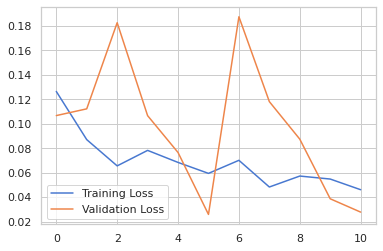

In [15]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [16]:
X_train_pred = model.predict(X_train)

train_mae_loss= pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [17]:
model.evaluate(X_test,y_test)

43/43 [==============================] - 2s 50ms/step - loss: 0.1295 - accuracy: 0.0000e+00


[0.12953707575798035, 0.0]

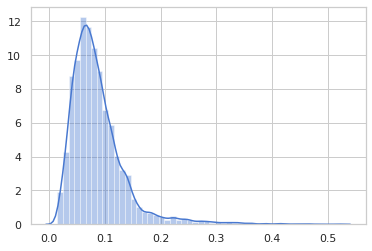

In [18]:
sns.distplot(train_mae_loss, bins =50, kde=True);

In [19]:
threshold = 0.3

In [20]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred- X_test), axis=1)

In [21]:

test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss']=test_mae_loss
test_score_df['threshold']=threshold
test_score_df['anomaly']=test_score_df.loss > test_score_df.threshold
test_score_df['close']=test[time_steps:].close

In [22]:

test_score_df.tail()

,date,close,loss,threshold,anomaly
7016,2019-12-24,5.164715,0.253340,0.3,False
7017,2019-12-26,5.118208,0.271479,0.3,False
7018,2019-12-27,5.182517,0.303101,0.3,True
7019,2019-12-30,5.179838,0.286019,0.3,False
7020,2019-12-31,5.132274,0.286097,0.3,False


In [23]:
test_score_df.tail()

,date,close,loss,threshold,anomaly
7016,2019-12-24,5.164715,0.253340,0.3,False
7017,2019-12-26,5.118208,0.271479,0.3,False
7018,2019-12-27,5.182517,0.303101,0.3,True
7019,2019-12-30,5.179838,0.286019,0.3,False
7020,2019-12-31,5.132274,0.286097,0.3,False


In [24]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss,mode='lines', name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold,mode='lines', name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [25]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,date,close,loss,threshold,anomaly
5949,2015-08-25,2.752765,0.305158,0.3,True
5950,2015-08-26,2.703097,0.317193,0.3,True
5951,2015-08-27,2.783844,0.346010,0.3,True
5956,2015-09-03,2.710932,0.317587,0.3,True
5958,2015-09-07,2.574776,0.323754,0.3,True


In [26]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=scaler.inverse_transform(test[time_steps:].close),mode='lines', name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.date, y=scaler.inverse_transform(anomalies.close),mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()